# Initialisation

In [52]:
### Load modules and data

import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import math
from scipy import stats
import pdb

%matplotlib inline


# Introduction

In this notebook I implement basic fine-mapping methods. Firstly I implement a basic method which calculated Bayes likelihood factors given sets of SNPs with their p-values, and the LD structure calculated from 1000 genomes.

### Single trait Bayes factor computation

In [6]:
s_tss_1=np.load('summary_stats_g1_tss60.npy')[0]
s_tss_2=np.load('summary_stats_g2_tss60.npy')[0]
LD_tss_1=np.load('LD_g1_TSS60.npy')
LD_tss_2=np.load('LD_g2_TSS60.npy')

### Generate z arrays

z1 = np.array(np.divide(s_tss_1['beta'],np.sqrt(s_tss_1['var_beta'])))
z2 = np.array(np.divide(s_tss_2['beta'],np.sqrt(s_tss_1['var_beta'])))
z1 = np.ndarray.flatten(z1)
z2 = np.ndarray.flatten(z2)

### Create selection of SNPs
def select_snps(z, subset):
    return [z[i] for i in subset]

#example
# for subset in it.combinations(range(len(z1)),3):
#     print subset, select_snps(z1, subset)    



### Select covariance submatrix

def select_cov(cov, subset):
    return cov[np.ix_(subset,subset)]

#example   
#select_cov(LD_tss_1, (0,1,5))

### Calculate Bayes Factor

def calc_BF(z, cov, v,n):
    z = np.matrix(z)
    z = z.T
    v = np.matrix(v)
    coeff = 1. / math.sqrt(np.linalg.det((np.matrix(np.eye(len(z))) + n * np.matrix(v) * np.matrix(cov))))
    exponent = 0.5* z.T * np.matrix(((n*v).I + cov)).I * z
    return np.array(math.log(coeff) + exponent)[0][0]

# example
# subset = (0,1,5,8)
# cov = select_cov(LD_tss_1, subset)
# z = select_snps(z1, subset)
# v = np.eye(len(z))/1000
# n = 1000
# calc_BF(z,cov,v,n)

def choose_variant_set(data,k,v):
    results = []
    for i in range(1,k):
        for subset in it.combinations(range(len(data[0])),i):
            z = select_snps(data[0], subset)
            cov = select_cov(data[1],subset)
            n = data[2]
            v_matrix = np.eye(len(z)) * v
            results.append((subset, calc_BF(z, cov,v_matrix,n)))
    results.sort(key=lambda x: x[1], reverse=True)
    return results[0:10]

k=5
data1 = (z1, LD_tss_1,10000)
data2 = (z2, LD_tss_2,1000)
v = 0.01
    
set1 = choose_variant_set(data1,k,v)
set2 = choose_variant_set(data2,k,v)



### Trait simulation

Given genotype data and an LD structure, simulate a trait which is linearly associated with a variant, or a set of variants. Here I generate a large mxn matrix (m=number of samples, n=number of SNPs), with 0,1,2 as elements.

Then, I can choose a set of SNPs, and from these SNPs I generate a trait with a linear model with a given parameter beta, as well as an unexplained variance parameter epsilon.

Following this, I try to recover these sets of SNPs. I generate p-values for each SNP being associated with the trait, by individually building univariate linear models for each SNPs, as I understand summary statistics are generated.

In [54]:
### Sample genotypes

def simulate_genotype(n,m,geno_dist):
    X=np.zeros([n,m])
    for i in range(m):
        X[:,i] = [np.random.choice(a=[0,1,2],p=geno_dist) for x in range(n)]
    return np.array(X)

###example
X = simulate_genotype(n=10000,m=30,geno_dist=[0.85,0.1,0.05])

In [56]:
def simulate_traits(X,eps,snp_group):
    """
    SNPs in the form e.g. {3: 0.9, 5:0.4, 8:0.5}. Dictionary values are the linear model coefficients (beta values).
    eps is the level of unexplained variance. X is the genotype information.
    """
    beta = np.array(snp_group.values()).T
    snps = snp_group.keys()
    eps_vector = np.array(np.random.normal(0,eps,X.shape[0])).T
    return np.add(np.dot(X[:,snps], beta), eps_vector)
    
###examples
y = simulate_traits(X,eps=0.5,snp_group={3: 5, 9: 3})

In [57]:
y

array([-0.35302832,  9.75995817,  4.50116152, ...,  5.37627002,
        6.14513579, -0.64105948])

(array([ 4418.,  2836.,   800.,   967.,   335.,   150.,   399.,    59.,
           12.,    24.]),
 array([ -1.72848038,   0.14866422,   2.02580882,   3.90295342,
          5.78009802,   7.65724262,   9.53438721,  11.41153181,
         13.28867641,  15.16582101,  17.04296561]),
 <a list of 10 Patch objects>)

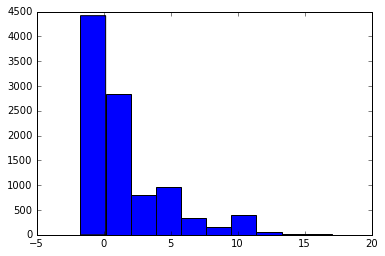

In [12]:
plt.hist(y)

In [40]:
stats.linregress(list(X[:,1][0:10]),list(y[0:10]))

ValueError: too many values to unpack

In [48]:
X.A1.shape

(300000,)

In [34]:
stats.linregress([3,2,1], [3,2,1])

LinregressResult(slope=1.0, intercept=0.0, rvalue=1.0, pvalue=9.0031631615710586e-11, stderr=0.0)

# Last section